In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/CASIA2/cnn_model_CASIAv2.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

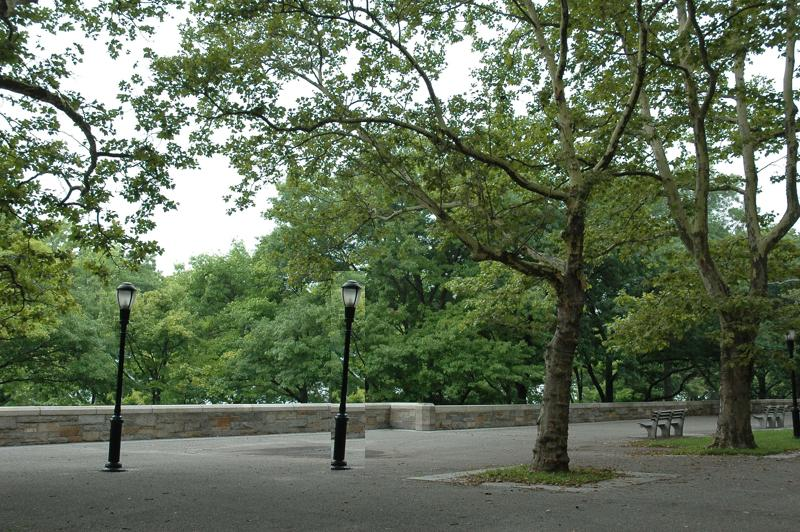

In [ ]:
real_image_path = r"/content/drive/MyDrive/test4.png"
Image.open(real_image_path)

In [ ]:
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten() / 255.0

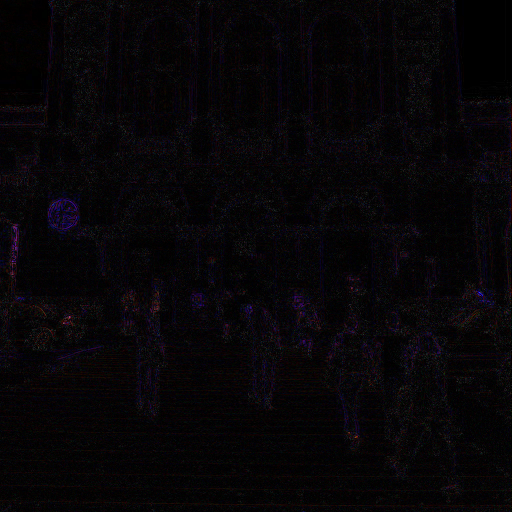

In [ ]:
convert_to_ela_image(real_image_path, 85)

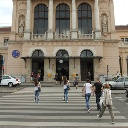

In [ ]:
import cv2

def prepare_image_for_size(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, target_size)
    return resized_image

# Path to the original image
original_image_path = r"/content/drive/MyDrive/test4.png"

# Prepare the image
resized_image = prepare_image_for_size(original_image_path, target_size=(128, 128))

# Save the resized image to a new path
resized_image_path = r"/content/drive/MyDrive/Colab Notebooks/resized_image4.jpg"
cv2.imwrite(resized_image_path, resized_image)

# Reshape the image for prediction
resized_image = resized_image.reshape(-1, 128, 128, 3)
Image.open(resized_image_path)

In [ ]:
import numpy as np
path = r"/content/drive/MyDrive/test4.png"
x2 = prepare_image(path)
x2 = x2.reshape(-1, 128, 128, 3)

In [ ]:
#TESTING THE IMAGE AND MAKING PREDICTION
arr = model.predict(x2)
print(arr)
res=0
if(arr[0][0]>arr[0][1]):
    res=1
    print("IMAGE IS TAMPERED")
else:
    res=0
    print("IMAGE IS AUTHENTICATED");

1/1 [==============================] - 0s 421ms/step
[[0.9940671  0.00593295]]
IMAGE IS TAMPERED


Localization is required


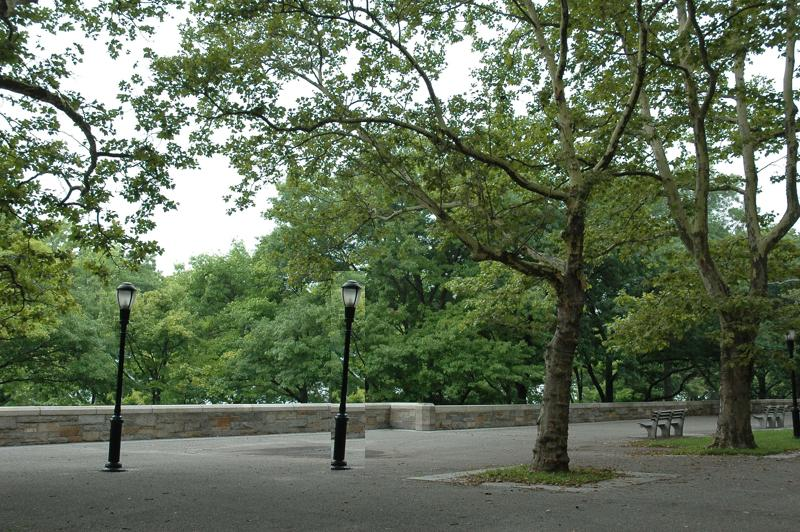

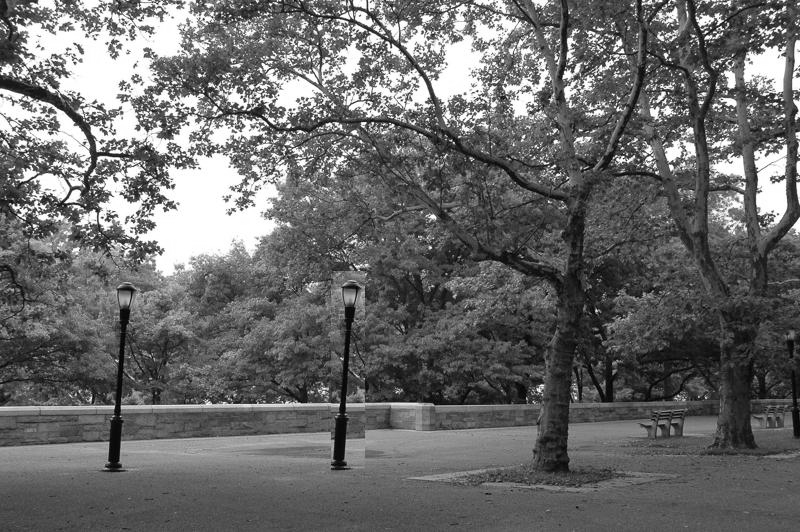

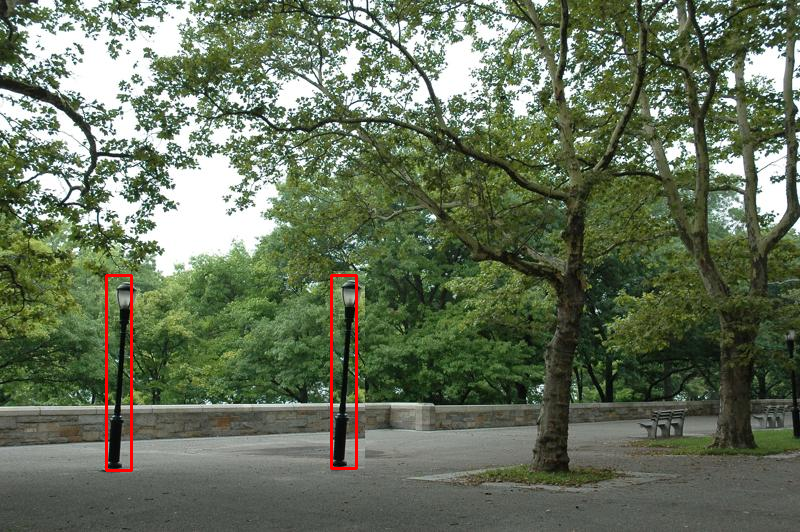

In [ ]:
import sys
import cv2
from sklearn.cluster import DBSCAN
import numpy as np
from google.colab.patches import cv2_imshow
def locateForgery(eps, min_sample, descriptors, key_points, image):
    l1=[]
    l2=[]
    clusters = DBSCAN(eps=eps, min_samples=min_sample).fit(descriptors)
    size = np.unique(clusters.labels_).shape[0] - 1
    forgery = image.copy()
    m=0
    #if (size == 0) and (np.unique(clusters.labels_)[0] == -1):
        #print('No Forgery Found!!')
        #return None
    if size == 0:
        size = 1
    cluster_list = [[] for i in range(size)]
    for idx in range(len(key_points)):
        if clusters.labels_[idx] != -1:
            cluster_list[clusters.labels_[idx]].append((int(key_points[idx].pt[0]), int(key_points[idx].pt[1])))
            if m<size:
              l1.append((int(key_points[idx].pt[0]),int(key_points[idx].pt[1])))
              m=m+1
             # print(m)
            else:
              l2.append((int(key_points[idx].pt[0]),int(key_points[idx].pt[1])))
    points=l1
    min_x1, min_y1 = min(points, key=lambda p: p[0])[0], min(points, key=lambda p: p[1])[1]
    max_x1, max_y1 = max(points, key=lambda p: p[0])[0], max(points, key=lambda p: p[1])[1]
    #print(min_x1,min_y1,max_x1,max_y1)


   # print(l1)
    #print(l2)
    for i in range((2)):
      # print(l1[i])
      if i==0:
        center_coordinates = min_x1,min_y1
      elif(i==1):
        center_coordinates=max_x1,max_y1
      elif(i==2):
        center_coordinates=max_x1
      elif(i==3):
        center_coordinates=max_y1

    points=l2
    min_x2, min_y2 = min(points, key=lambda p: p[0])[0], min(points, key=lambda p: p[1])[1]
    max_x2, max_y2 = max(points, key=lambda p: p[0])[0], max(points, key=lambda p: p[1])[1]
    for i in range((2)):
      # print(l1[i])
      if i==0:
        center_coordinates = min_x2,min_y2
      elif(i==1):
        center_coordinates=max_x2,max_y2
      elif(i==2):
        center_coordinates=max_x2
      elif(i==3):
        center_coordinates=max_y2
# Radius of circle
    radius = 3
# Red color in BGR
    color = (0, 0, 255)
# Line thickness of -1 px
    thickness = -1
    # forgery = cv2.circle(forgery, center_coordinates, radius, color, thickness)
    cv2.rectangle(forgery, (min_x1-10, min_y1-10), (max_x1+10, max_y1+10), (0, 0, 255), 2)
    cv2.rectangle(forgery, (min_x2-10, min_y1-10), (max_x2+10, max_y2+10), (0, 0, 255), 2)




# Radius of circle
#       radius = 3

# # Red color in BGR
#       color = (0, 0, 255)

# # Line thickness of -1 px
#       thickness = -1
      # forgery = cv2.circle(forgery, center_coordinates, radius, color, thickness)
      # cv2.rectangle(forgery, (min_x, min_y), (max_x, max_y), (0, 0, 255), 2)
      # cv2_imshow(forgery)
    return forgery

def siftDetector(image):
    sift = cv2.xfeatures2d.SIFT_create()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print()
    cv2_imshow(gray)
    print()
    key_points, descriptors = sift.detectAndCompute(gray, None)
    return key_points, descriptors
def local(path):
  image = cv2.imread(path)
  cv2_imshow(image)
  key_points, descriptors = siftDetector(image)
  forgery = locateForgery(40, 2, descriptors, key_points, image)
  #cv2_imshow(image)
  cv2_imshow(forgery)
if res:
    print("Localization is required")
    local(path)
else:
    print("Image is Authenticated")